# 4. 캐글 경진대회 도전 (2) : 주택 가격 예측
## 4.1 더 상세하게 알아보는 데이터 분석
 - 데이터 분석 방법을 좀 더 상세히 알아보기
 - 여러 머신 러닝 방법의 설계 및 조합
 - 추가 분석 (1) : 클러스터 분석에 따른 주택 분류
 - 추가 분석 (2) : 고급 주택의 조건 분석 및 시각화
 
## 4.2 주택 가격 예측하기 경진대회란

예측 정확도 평가는 평균 제곱 오차(RMSE, Root Mean Squared Error)를 사용하며, 정답 데이터와 차이가 작을수록 상위를 차지합니다.


**분류(classification)**

|ID|Survived|
|-----|-----|
|0|1|
|1|1|
|2|0|
|3|1|
|4|0|

**회귀(regression)**

|ID|SalePrice|
|-----|-----|
|0|112,310|
|1|145,560|
|2|219,200|
|3|186,500|
|4|134,365|

평가 항목(evaluation)을 보면 Taking logs mean that errors in predicting expensive houses and cheap houses will affect the result equally

## 4.3 데이터 내려받기

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [2]:
import pandas as pd
import numpy as np

#### 랜덤 시드 설정하기

In [3]:
import random
np.random.seed(1234)
random.seed(1234)

#### CSV 데이터 불러오기(아나콘다(윈도), 맥에서 주피터 노트북 이용)

In [4]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [5]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 4.4 벤치마크용 베이스라인 작성

먼저 최소한의 카테고리 변수를 라벨 인코딩 처리한 후 LightGBM에 넣었을 때 정확도가 얼마인지 알아보겠습니다. 이것은 이후 처리가 정확도 향상에 얼마나 효과가 있었는지 검증하기 위해서 입니다.

### 4.4.1 LightGBM으로 예측

각 변수의 중요도를 나타낼 수 있기 때문에 향후 처리의 우선순위 등을 생각하는 지표로 활용될 수 있음

#### 학습 데이터의 변수 유형 확인하기
학습 데이터 각 변수의 유형을 **dtypes 명령어**로 확인할 수 있습니다

In [6]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [7]:
train_df["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### 학습 데이터와 테스트 데이터를 합해서 전처리하기
LabelEncoder는 카테고리를 연속적인 수치로 변환합니다. 이때 **주의할 점**은 학습 데이터만 변환시킬 때는 테스트 데이터에만 존재하는 변수를 만나면 오류를 발생한다는 것

LabelEncoder를 처리하기 전에 결측치(NaN)를 미리 임의의 문자열(예를 들어 missing 등)로 변환하거나 삭제

data discription 파일에서 NA인 것에 의미가 있다면(예를 들어 차고(Garage) 값이 NaN일 때는 차고가 없다는 의미) NaN을 삭제하기보다 missing처럼 결손을 나타내는 다른 값으로 대체하는 것이 좋다.

판다스의 데이터프레임은 pd.concat() 함수로 연결할 수 있습니다. 인덱스가 중복되므로 reset_index() 함수로 인덱스 새로 매김, (drop=True) 옵션을 이용하여 원래 index 행은 삭제

In [8]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [9]:
all_df["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

#### 카테고리 변수를 수치로 변환하기
all_df의 object형 카테고리 변수를 수치로 변환. 우선은 LabelEncoder의 라이브러리를 불러옵니다.

In [11]:
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes=="object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [13]:
all_df["Alley"].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

#### 결측치를 수치로 변환하기
categories에 저장된 카테고리 변수를 하나씩 호출하여 결측치를 missing으로 변환한 후 LabelEncoder를 사용하여 수치로 바꾸어 줍니다. 단순한 숫자로 변환되므로 이것이 카테고리 변수임을 명시하고자 마지막에 astype("category")로 하겠습니다.

In [14]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True) #
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [15]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


#### 학습 데이터와 테스트 데이터로 되돌리기

이렇게 해서 LightGBM 등 각종 머신 러닝 모델에서 데이터를 읽을 수 있게 되었습니다. 이제 다시 train_df와 test_df로 되돌려 놓겠습니다.

isnull()로 null 행을 판정할 수 있는데, all_df["SalePrice"].isnull()을 실행하여 SalePrice의 null 행을 분리하면 이것이 테스트 데이터가 됩니다.

In [16]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

#### LightGBM으로 데이터 읽기

In [17]:
import lightgbm as lgb

### 4.4.2 교차 검증으로 모델 학습과 예측
이제 학습 데이터를 세 개로 분할하고, 각 데이터로 모델을 작성한 후 테스트 데이터에 대한 예측 정확도 평균을 구해 보겠습니다.

#### 교차 검증용 라이브러리 설정하기
우선 교차 검증용 라이브러리를 불러오고, 분할할 데이터 수를 3으로 설정합니다


In [18]:
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

#### 하이퍼 파라미터 설정하기
다음으로 LightGBM의 하이퍼파라미터 설정합니다. 나중에 다시 조정하기 때문에 여기서는 일단 회귀 분석용 모델인 Objective, regression만 설정하겠습니다.

In [19]:
lgbm_params = {
    "objective" : "regression",
    "random_sedd" : 1234
}

#### 설명 변수와 목적 변수 지정하기
교차 검증을 수행하기 전에 설명 변수와 목적 변수를 지정합니다. 목적 변수는 SalePrice입니다. 설명 변수는 원래 데이터에서 SalePrice와 학습에 불필요한 Id를 삭제하는 것입니다.

In [20]:
train_X = train_df_le.drop(["SalePrice", "Id"], axis = 1)
train_Y = train_df_le["SalePrice"]

#### 평균 제곱 오차 라이브러리 불러오기
이번 경진대회의 평기 지표가 RMSE이므로 이를 구하는 라이브러리도 임포트합니다. RMSE는 평균 제곱 오차 제곱근이므로, 평균 제곱 오차를 구하는 라이브러리를 임포트 합니다.

In [21]:
from sklearn.metrics import mean_squared_error

#### 모델별 예측 값 저장하기
fold별로 작성한 모델을 models에 저장하고, rmse의 계산 결과를 rmses에 저장합니다. 동시에 oof(out of fold)(해당 데이터를 제외한 나머지 데이터를 이용하여 목적 변수를 예측한 값)를 저장합니다.

off는 초깃값을 0으로 하고, fold마다 해당하는 인덱스 값을 갱신합니다. np.zeros() 함수로 임의의 길이만큼 0으로 채운 배열(정확히는 넘파이의 ndarray, 같은 유형의 값을 저장할 수 있는 다차원 배열)을 작성할 수 있습니다. kf.split() 함수로 train_X를 분할한 결과의 인덱스를 얻고, 이를 바탕으로 학습 데이터와 검증 데이터를 지정한 후 LightGBM을 실행하겠습니다

In [26]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                         verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.59541e+09
[20]	valid_0's l2: 7.467e+08
[30]	valid_0's l2: 5.96558e+08
[40]	valid_0's l2: 5.49479e+08
[50]	valid_0's l2: 5.29299e+08
[60]	valid_0's l2: 5.28785e+08
[70]	valid_0's l2: 5.32577e+08
Early stopping, best iteration is:
[57]	valid_0's l2: 5.26368e+08
0.12637668452645173
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 2.08125e+09
[20]	valid_0's l2: 1.23117e+09
[30]	valid_0's l2: 1.04155e+09
[40]	valid_0's l2: 9.92123e+08
[50]	valid_0's l2: 9.69222e+08
[60]	valid_0's l2: 9.54807e+08
[70]	valid_0's l2: 9.50536e+08
[80]	valid_0's l2: 9.45353e+08
[90]	valid_0's l2: 9.40359e+08
[100]	valid_0's l2: 9.36486e+08
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 9.36066e+08
0.15229205843857013
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.78839e+09
[20]	valid_0's l2: 1.03494e+09
[30]	valid_0's l2: 8.77181e+08
[40]	valid_0'

#### 평균 RMSE 계산하기
리스트 합계를 sum()으로 구하고 len()에서 리스트의 요소 개수를 구해서 합계를 요소 개수로 나누어 평균을 냅니다.

In [27]:
sum(rmses)/len(rmses)

0.13697846250952908

In [28]:
from statistics import mean
mean(rmses)

0.13697846250952908

#### 현재 예측 값과 실제 값 차이 확인하기
예측 값은 off고, 실제 값은 train_Y이므로 이 정보를 데이터 프레임에 저장한 후 시각화해 보겠습니다.

<AxesSubplot:>

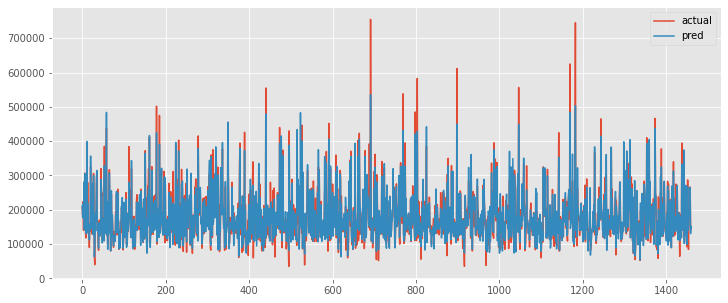

In [31]:
actual_pred_df = pd.DataFrame({
    "actual" : train_Y,
    "pred" : oof
})

actual_pred_df.plot(figsize=(12, 5))